In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn. metrics import classification_report, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("shopee_final.csv", encoding="utf-8", index_col=0)

In [3]:
df.head()

,processed_text,class
0,miếng dán hơi dầy không_thẩm,neutral
1,miếng dán tồi bóc bụi giải_quyết thỏa_đáng điệ...,neutral
2,cường_lực trắng màu đen,not like
3,hàng cảm_quan đầu mặt xước dã dán chiều tối xư...,not like
4,chất_lượng cường_lực chống trộm không_như quản...,not like


### TF-IDF Vectorizer

In [4]:
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.02)

In [5]:
# Fit the TfidfVectorizer object to the data
x = tfidf_vectorizer.fit(df['processed_text'].values.astype('U'))

In [6]:
# Transform the data
X = tfidf_vectorizer.transform(df['processed_text'].values.astype('U'))

In [7]:
### BUG: 
# This is probably because you are using an older scikit-learn version than the one this code was written for.
# get_feature_names_out is a method of the class sklearn.feature_extraction.text.TfidfVectorizer since scikit-learn 1.0. Previously, there was a similar method called get_feature_names.
# So you should update your scikit-learn package, or use the old method (not recommended).
# Create a new dataframe with the transformed data
df_new = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [8]:
df_new.head()

,chất,chất vải,chất_liệu,chất_lượng,chất_lượng sản_phẩm,giá,giá tiền,gói,gói sản_phẩm,gửi,...,đóng,đóng gói,đóng_gói,đóng_gói sản_phẩm,đẹp,đẹp phục_vụ,đổi,ảnh,ổn,ủng_hộ
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.445574,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.508217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y = df['class']

In [14]:
print(X.shape, y.shape)

(616517, 55) (616517,)


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model Comparision

In [16]:
models = [
    LogisticRegression(multi_class='multinomial', max_iter=1000),
    MultinomialNB(),
    RandomForestClassifier()
    
]

In [17]:
def get_model_name(model):
    model_name = model.__class__.__name__
    return model_name

In [18]:
# Dataframe to store the model selection results
cv_df = pd.DataFrame(columns=['model', 'accuracy_train', 'accuracy_test', 'time'])

# Loop through the models
for model in models:
    # Get the model name
    model_name = get_model_name(model)
    if model_name == 'LogisticRegression':
        log_class = LogisticRegression(multi_class='multinomial', max_iter=1000)
        log_class.fit(X_train, y_train)
        y_pred_log = log_class.predict(X_test)
    elif model_name == 'MultinomialNB':
        NB_class = MultinomialNB()
        NB_class.fit(X_train, y_train)
        y_pred_NB = NB_class.predict(X_test)
    else:
        Rd_class = RandomForestClassifier()
        Rd_class.fit(X_train, y_train)
        y_pred_Rd = Rd_class.predict(X_test)
    # Get the start time
    start_time = datetime.now()
    # Get the end time
    end_time = datetime.now()
    # Get the time taken to train the model
    time_taken = end_time - start_time
    # Get the accuracy score for the model
    model.fit(X_train, y_train)
    accuracy_train = round(model.score(X_train, y_train) * 100, 3)
    accuracy_test = round(model.score(X_test, y_test) * 100, 3)
    # Append the model name and score to the dataframe
    cv_df = pd.concat([cv_df, pd.DataFrame.from_records([  #cv_df = cv_df.append(
        {
            'model': model_name,
            'accuracy_train': accuracy_train,
            'accuracy_test': accuracy_test,
            'time': str(time_taken),
        }])],
                      ignore_index=True,

                      )

### Metric result

In [19]:
metrics = cv_df.sort_values(by=['time'], ascending=False)
metrics

,model,accuracy_train,accuracy_test,time
1,MultinomialNB,63.513,63.550,0:00:00.000006
2,RandomForestClassifier,75.863,69.289,0:00:00.000005
0,LogisticRegression,69.128,69.162,0:00:00.000004


###
- Generally, Logistic Regression is better than the others based on Accuracy

### Classification Report

###
- in this project, High Recall should be taken into consideration in Negative class
- high recall means high True rating negative, we should avoid wrong rating that negative comments is predicted positive rating

In [22]:
### Logistic Reg
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

        like       0.76      0.83      0.80     95738
     neutral       0.69      0.18      0.28     33500
    not like       0.59      0.76      0.66     55718

    accuracy                           0.69    184956
   macro avg       0.68      0.59      0.58    184956
weighted avg       0.70      0.69      0.66    184956



In [23]:
### Naive Bayes
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

        like       0.69      0.80      0.74     95738
     neutral       0.53      0.22      0.31     33500
    not like       0.56      0.61      0.58     55718

    accuracy                           0.64    184956
   macro avg       0.59      0.54      0.55    184956
weighted avg       0.62      0.64      0.62    184956



In [24]:
### Random Tree
print(classification_report(y_test, y_pred_Rd))

              precision    recall  f1-score   support

        like       0.78      0.82      0.80     95738
     neutral       0.58      0.21      0.31     33500
    not like       0.59      0.77      0.67     55718

    accuracy                           0.69    184956
   macro avg       0.65      0.60      0.59    184956
weighted avg       0.69      0.69      0.67    184956



### 
- from the requirement, Logistic Model will be used for prediction

### Logistic Regression

#### Hyperparameter tuning

In [29]:
# Use GridSearchCV to find the best parameters for the models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Create a list of parameters of Logistic Regression for the GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
#param_grid = {
    #'n_estimators': [100,300, 500, 1000],
    #'learning_rate':[0.001,0.01,0.1, 1]
#}
# Create a list of models to test
clf_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy', error_score=0)
search_clf = clf_grid.fit(X_train, y_train)
best_clf = search_clf.best_estimator_

##Score
#cross_clf = cross_val_score(best_clf, X_test, y_test, scoring='accuracy', cv=5, n_jobs=-1)

In [30]:
print('Best params:', search_clf.best_params_)

Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


### Best Params

In [32]:
## Create the best model
best_model = LogisticRegression(C= 1.0,penalty='l2',solver= 'newton-cg')
# Fit the best model to the training data
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

### Metrics to Report

In [33]:
# Get the accuracy score for the best model
accuracy_train = round(best_model.score(X_train, y_train) * 100, 3)
accuracy_test = round(best_model.score(X_test, y_test) * 100, 3)
print('Accuracy score for the best model on the training data: ', accuracy_train)
print('Accuracy score for the best model on the test data: ', accuracy_test)

Accuracy score for the best model on the training data:  69.129
Accuracy score for the best model on the test data:  69.162


              precision    recall  f1-score   support

        like       0.76      0.83      0.80     95738
     neutral       0.69      0.18      0.28     33500
    not like       0.59      0.76      0.66     55718

    accuracy                           0.69    184956
   macro avg       0.68      0.59      0.58    184956
weighted avg       0.70      0.69      0.66    184956



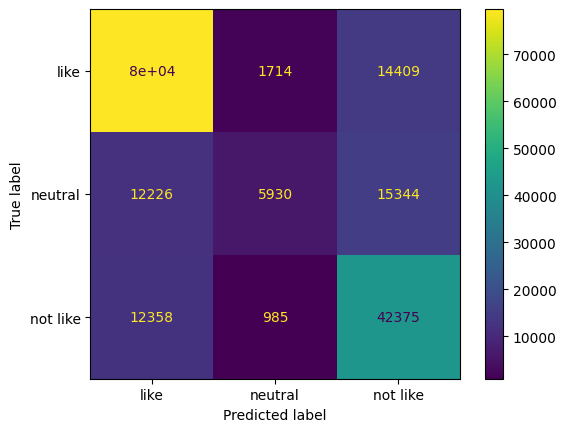

In [35]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

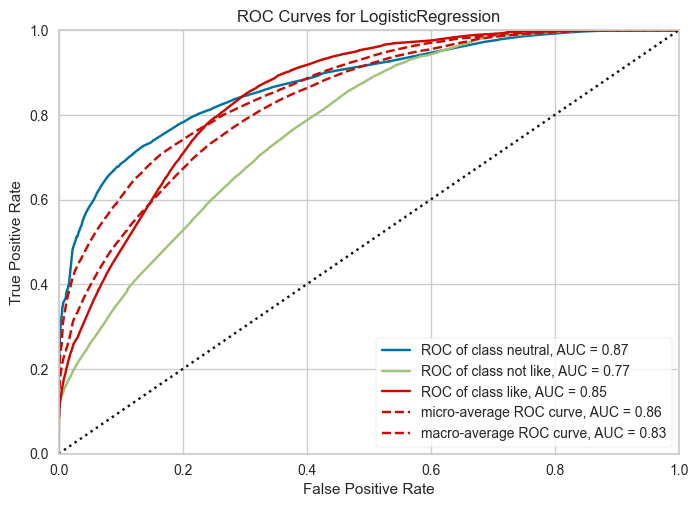

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [38]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, roc_auc
visualizer = ROCAUC(best_model, classes=y.unique())

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()